In [1]:
import pvl
import struct
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os.path
import binascii

In [2]:
mimap_file = '/Users/kdlee/builds/ISIS3/isis/tests/data/mimap2isis/MI_MAP_02_N65E328N64E329SC.img'
mi_l3C_file = '/Users/kdlee/Desktop/MIA_3C5_03_01351S791E0024SC.IMG'
image_file = mi_l3C_file

In [3]:
header = pvl.load(mi_l3C_file)
header

PVLModule([
  ('PDS_VERSION_ID', 'PDS3')
  ('RECORD_TYPE', 'UNDEFINED')
  ('FILE_NAME', 'MIA_3C5_03_01351S791E0024SC.img')
  ('PRODUCT_ID', 'MIA_3C5_03_01351S791E0024SC')
  ('DATA_FORMAT', 'PDS')
  ('^GEOMETRIC_DATA_ALTITUDE', Quantity(value=12628, units='BYTES'))
  ('^IMAGE', Quantity(value=31213828, units='BYTES'))
  ('SOFTWARE_NAME', 'RGC_TC_MI_PLUS')
  ('SOFTWARE_VERSION', '4.0.0')
  ('PROCESS_VERSION_ID', 'L3C')
  ('PRODUCT_CREATION_TIME',
   datetime.datetime(2014, 11, 15, 12, 8, 44, tzinfo=datetime.timezone.utc))
  ('PROGRAM_START_TIME',
   datetime.datetime(2014, 11, 13, 4, 40, 5, tzinfo=datetime.timezone.utc))
  ('PRODUCER_ID', 'LISM')
  ('PRODUCT_SET_ID', 'MI_Level3C5')
  ('PRODUCT_VERSION_ID', '03')
  ('REGISTERED_PRODUCT', 'Y')
  ('LEVEL2A_FILE_NAME', 'MV52A0_02NL01351_003_0029.img')
  ('LEVEL2C_FILE_NAME', 'MV5_2C5_03_01351S791E0024.img')
  ('SPICE_METAKERNEL_FILE_NAME',
   'RGC_INF_TCv401IK_MIv200IK_SPv105IK_RISE100i_05_100h_02_LongCK_DS_V02_de421_131210.mk')
  ('MISSION_

In [4]:
with open(mi_l3C_file, 'rb') as f:
    try:
        image_offset = header["^IMAGE"].value-(header['IMAGE']['SAMPLE_BITS']//8)
        f.seek(image_offset)
        b_image_data = f.read()
    except AttributeError:
        # If detached label, "^IMAGE" will be a list.
        image_file = os.path.dirname(mi_l3C_file) + "/" + header["^IMAGE"][0]
        image_offset = header["^IMAGE"][1].value
        with open(image_file, 'rb') as im_f:
            b_image_data = im_f.read()

In [5]:
n_lines = 5
n_samples = 5
line_length = header['IMAGE']['LINE_SAMPLES'] * (header['IMAGE']['SAMPLE_BITS']//8)

In [6]:
image_data = []
# For MI_L3C: Use a good subset of the data.
# Starting at the top left corner resulted in all NULL pixels.
line_offset = 40
sample_offset = 3000
for j in range(line_offset, n_lines * header['IMAGE']['BANDS'] + line_offset + 1):
    image_sample = np.frombuffer(b_image_data[j*line_length:(j+1)*line_length], dtype=np.int16, count=int(line_length/2))
    image_data.append(image_sample)
image_data = np.array(image_data)
image_data = image_data[:, sample_offset:sample_offset + n_samples]

In [7]:
image_data.shape

(46, 5)

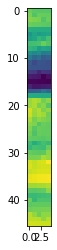

In [8]:
plt.imshow(image_data)

In [9]:
class RealIsisCubeLabelEncoder(pvl.encoder.ISISEncoder):    
    def encode_time(self, value):
        if value.microsecond:
            second = u'%02d.%06d' % (value.second, value.microsecond)
        else:
            second = u'%02d' % value.second

        time = u'%02d:%02d:%s' % (value.hour, value.minute, second)
        return time

In [10]:
image_fn, image_ext = os.path.splitext(image_file)
crop = '_cropped'
mini_image_fn = image_fn + crop + image_ext
mini_image_bn = os.path.basename(mini_image_fn)

grammar = pvl.grammar.ISISGrammar()
grammar.comments+=(("#", "\n"), )
encoder = RealIsisCubeLabelEncoder()

# Overwrite the number of lines and samples in the label
header['IMAGE']['LINES'] = n_lines
header['IMAGE']['LINE_SAMPLES'] = n_samples

if mi_l3C_file != image_file:
    # If detached label, point the mini label to the mini image
    header['^IMAGE'] = [mini_image_bn, pvl.collections.Units(1, 'BYTES')]
    header['FILE_NAME'] = mini_image_bn
else:
    # If attached label, calculate the new offset
    header['^IMAGE'] = pvl.collections.Units(len(pvl.dumps(header, encoder=encoder, grammar=grammar)), 'BYTES')

In [11]:
label_fn, label_ext = os.path.splitext(mi_l3C_file)
out_label = label_fn + crop + label_ext

pvl.dump(header, out_label, encoder=encoder, grammar=grammar)

10183

In [12]:
with open(mini_image_fn, 'ab+') as f:
    b_reduced_image_data = image_data.tobytes()
    f.seek(0, 2)
    f.write(b'\n')
    f.write(b_reduced_image_data)